In [ ]:
#TODO
#1. three different tokenization scheme: 0-1, BPE, using commas+BPE

In [3]:
import os
import torch
from datasets import Dataset
from transformers import (
    GPT2Config,
    AutoModelForCausalLM,
    Trainer,
    TrainingArguments,
    DataCollatorForLanguageModeling,
    PreTrainedTokenizerFast
)
import numpy as np
from triangle_free import greedy_search_from_startpoint, empty_starting_point, reward_calc
from typing import List, Tuple
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tqdm.auto import tqdm
import random
import logging
import matplotlib.pyplot as plt
from multiprocessing import Pool

In [4]:
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [6]:
N = 20

In [50]:
def plot_histogram(rewards: List[float], bins: int = 40):
        """
        Plot and save a histogram of rewards.
        
        Args:
            rewards: List of rewards to plot
            generation: Generation number
            output_dir: Directory to save the plot
        """
        plt.figure(figsize=(10, 6))
        plt.hist(rewards, bins=bins, alpha=0.75, color='blue', edgecolor='black')
        plt.title(f'Reward Distribution')
        plt.xlabel('Reward')
        plt.ylabel('Frequency')
        plt.grid(True)
        # plt.savefig(os.path.join(output_dir, f'reward_histogram_gen_{generation}.png'))
        # plt.close()
        plt.show()


def _generate_sample(_):
    empty = empty_starting_point(N)
    graph = greedy_search_from_startpoint(None, empty, N)
    reward = reward_calc(graph, N)
    return {"text": graph, "reward": reward}

def generate_initial_dataset(num_samples: int = 40000) -> Dataset:
    """
    Generate initial dataset by running greedy search from empty graphs.
    
    Args:
        num_samples: Number of samples to generate
    
    Returns:
        HuggingFace Dataset containing the generated graphs
    """
    dataset_path = f"data/dataset_N{N}_samples{num_samples}"
    if os.path.exists(dataset_path):
        print(f"Loading dataset from {dataset_path}...")
        dataset = Dataset.load_from_disk(dataset_path)
    else:
        print(f"Generating initial dataset with {num_samples} samples...")
        
        # Generate samples using multiprocessing
        with Pool() as pool:
            samples = list(tqdm(pool.imap_unordered(_generate_sample, range(num_samples)), total=num_samples))
        
        dataset = Dataset.from_list(samples)
    return dataset

In [14]:
dataset = generate_initial_dataset(num_samples=40000)

Generating initial dataset with 40000 samples...


  0%|          | 0/40000 [00:00<?, ?it/s]

In [4]:
from datasets import Dataset
N=20
dataset = Dataset.load_from_disk(f"data/dataset_N{N}_samples40000")

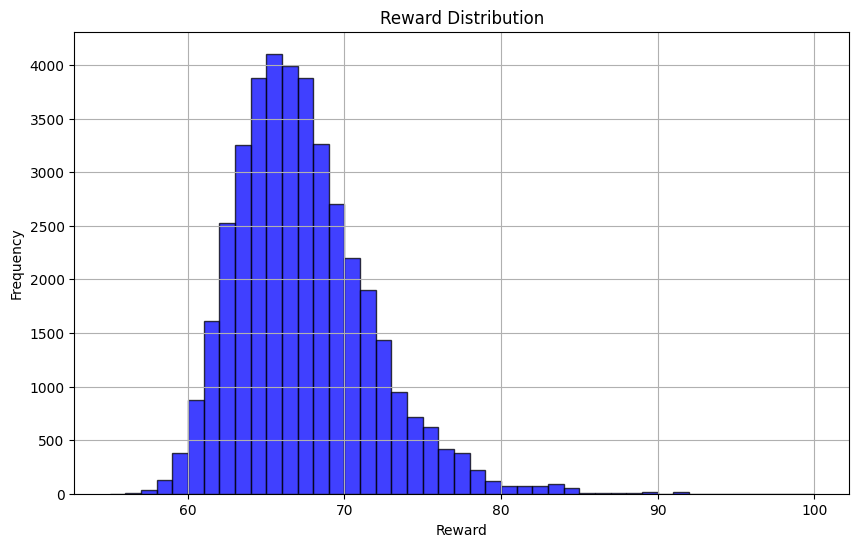

In [5]:
plot_histogram(dataset["reward"], bins=45)

In [26]:
dataset.save_to_disk(f"data/dataset_N{N}_samples40000")

Saving the dataset (0/1 shards):   0%|          | 0/40000 [00:00<?, ? examples/s]

In [5]:
# Sort by reward and keep top 25%
dataset = dataset.sort("reward", reverse=True)
best_dataset = dataset.select(range(len(dataset) // 4))

In [ ]:
# Combine the samples and rewards
combined = list(zip(samples, rewards))

# Sort by reward in descending order
combined_sorted = sorted(combined, key=lambda x: x[1], reverse=True)

# Take the top 25%
top_n = len(combined_sorted) // 4
samples, rewards = zip(*combined_sorted[:top_n])
samples = list(samples)
rewards = list(rewards)

In [85]:
import pickle
with open('rewards_final.pkl', 'rb') as f:
    rewards_final = pickle.load(f)

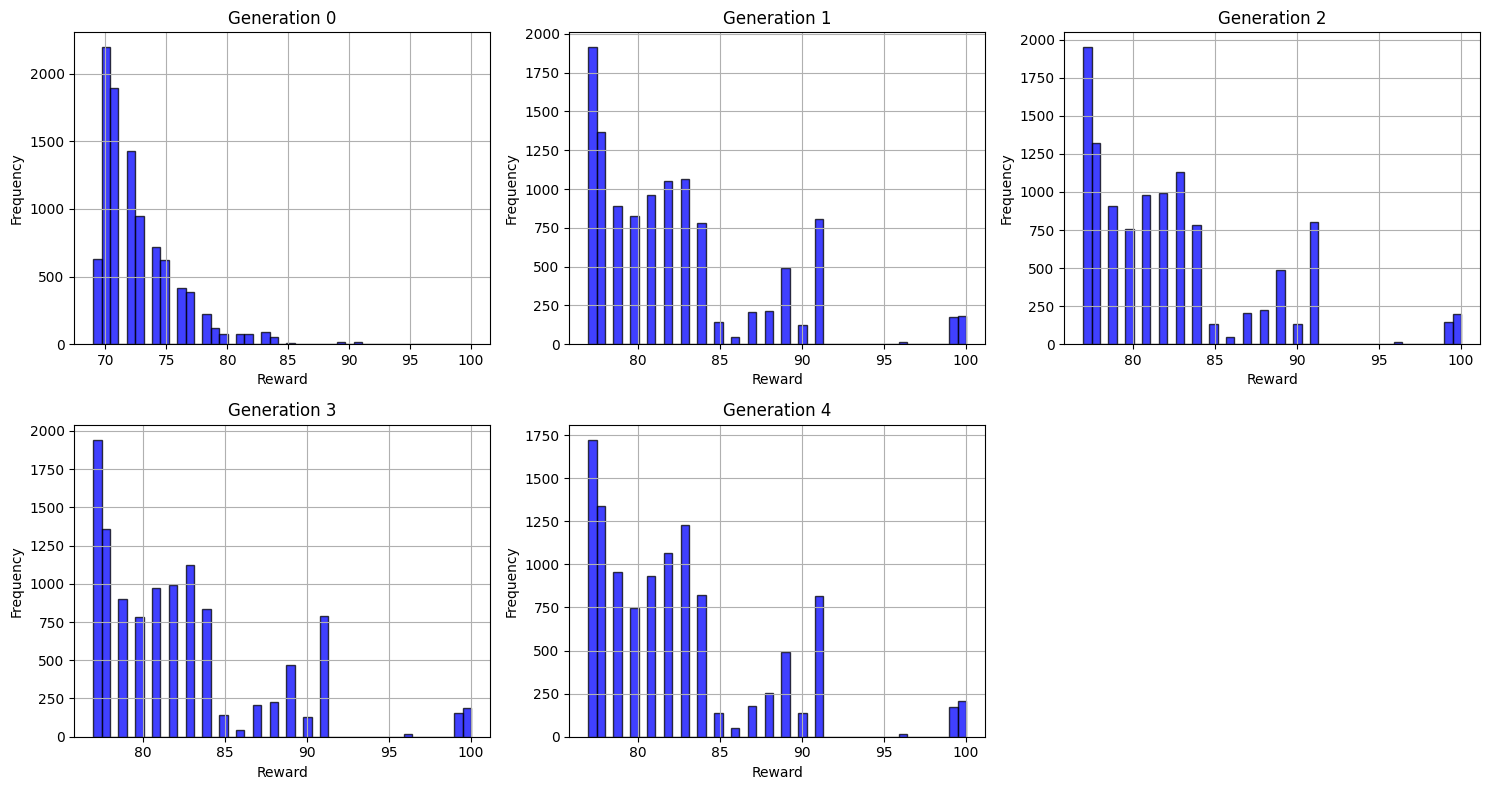

In [86]:
import math

num_plots = len(rewards_final)
cols = 3  # Number of columns for subplots
rows = math.ceil(num_plots / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()  # flatten to ease iteration

for i, (gen, rewards) in enumerate(rewards_final.items()):
    axes[i].hist(rewards, bins=45, alpha=0.75, color='blue', edgecolor='black')
    axes[i].set_title(f"Generation {gen}")
    axes[i].set_xlabel("Reward")
    axes[i].set_ylabel("Frequency")
    axes[i].grid(True)

# Turn off empty subplots
for ax in axes[num_plots:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [83]:
# Create a new list with commas inserted between characters for each string in best_dataset["text"]
modified_texts = [','.join(text) for text in best_dataset["text"]]

# Optionally, add the modified texts as a new column in best_dataset
best_dataset = best_dataset.add_column("modified_text", modified_texts)

# Print the first 5 modified strings to verify the changes
print(modified_texts[:5])

ValueError: The table can't have duplicated columns but columns ['modified_text'] are duplicated.

In [7]:
with open("best_dataset_text.txt", "w") as f:
    f.write("\n".join(modified_texts))

In [ ]:
# preprocessing of the input text file
with open("best_dataset_text.txt", 'r') as f:
    data = f.read()
words = data.splitlines()
words = [w.strip() for w in words] # get rid of any leading or trailing white space
words = [w for w in words if w] # get rid of any empty strings
words = [w.split(",") for w in words]

# maybe a tad hacky: we sort our dataset so that it is ordered V1, V2, .... V10, V11 ....
chars = sorted(list(set([i for word in words for i in word])), key=lambda x: int(x[1:]))

ValueError: invalid literal for int() with base 10: ''

In [ ]:

        tokenizer = Tokenizer(BPE())
        tokenizer.pre_tokenizer = Whitespace()
    
        trainer = BpeTrainer(vocab_size=n_tokens)

        source_file_path = args.dump_path+'/search_output_1.txt'
        destination_file_path = args.dump_path+"/temp.txt"

        with open(source_file_path, 'r') as source_file, open(destination_file_path, 'w') as destination_file:
            for i in range(5_000):
                line = source_file.readline()
                if not line:
                    break
                destination_file.write(line)



        tokenizer.train([destination_file_path], trainer)
        tokenizer.save(tokenizer_file)


    # input_file_path = input_path
    with open(input_file_path, "r") as file:
        text_data = [line.strip() for line in file]

    # Now create tokenized output file
    token_file_out = input_file_path.rsplit('.', 1)[0] + '-tokenized.txt'
    with open(token_file_out, "w") as file:
        print("Tokenizing training set...")
        for i, sequence in enumerate(text_data):
            if i % 10000 == 0:
                logger.info(f"{i} / {len(text_data)}")
            myids = tokenizer.encode(sequence).ids
            file.write(','.join(["V" + str(id) for id in myids]))
            file.write("\n")

In [15]:
from tokenizers.trainers import BpeTrainer
from tokenizers import Tokenizer
from tokenizers.pre_tokenizers import Whitespace
tokenizer = Tokenizer(BPE())
tokenizer.pre_tokenizer = Whitespace()

trainer = BpeTrainer(vocab_size=100)

In [20]:
tokenizer.train_from_iterator(best_dataset['text'][:5000], trainer=trainer)

In [21]:
text_data = best_dataset['text']
with open("best_dataset_tokenized.txt", "w") as file:
    for i, sequence in enumerate(text_data):
        if i % 10000 == 0:
            print(f"{i} / {len(text_data)}")
        myids = tokenizer.encode(sequence).ids
        file.write(','.join(["V" + str(id) for id in myids]))
        file.write("\n")

0 / 10000


In [22]:
from makemoretokens import generate, Transformer, ModelConfig

In [ ]:
config = ModelConfig(vocab_size=101, block_size=42,
                       n_layer=2, n_head=4,
                       n_embd=16, n_embd2=32)
model = Transformer(config)
model.load_state_dict(torch.load("out/model.pt"))
model.to("cuda:3")

number of parameters: 0.01M


In [26]:
model.load_state_dict(torch.load("out/model.pt"))

/tmp/ipykernel_2304698/1082120002.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("out/model.pt"))


<All keys matched successfully>

In [28]:
model.to("cuda:3")

Transformer(
  (transformer): ModuleDict(
    (wte): Embedding(101, 16)
    (wpe): Embedding(42, 16)
    (h): ModuleList(
      (0-1): 2 x Block(
        (ln_1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=16, out_features=48, bias=True)
          (c_proj): Linear(in_features=16, out_features=16, bias=True)
        )
        (ln_2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (mlp): ModuleDict(
          (c_fc): Linear(in_features=16, out_features=64, bias=True)
          (c_proj): Linear(in_features=64, out_features=16, bias=True)
          (act): NewGELU()
        )
      )
    )
    (ln_f): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=16, out_features=101, bias=False)
)

In [29]:
model.eval()

Transformer(
  (transformer): ModuleDict(
    (wte): Embedding(101, 16)
    (wpe): Embedding(42, 16)
    (h): ModuleList(
      (0-1): 2 x Block(
        (ln_1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=16, out_features=48, bias=True)
          (c_proj): Linear(in_features=16, out_features=16, bias=True)
        )
        (ln_2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (mlp): ModuleDict(
          (c_fc): Linear(in_features=16, out_features=64, bias=True)
          (c_proj): Linear(in_features=64, out_features=16, bias=True)
          (act): NewGELU()
        )
      )
    )
    (ln_f): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=16, out_features=101, bias=False)
)

In [55]:
X_init = torch.zeros(100000, 1, dtype=torch.long).to("cuda:3")
X_samp = generate(model, X_init, 189, temperature = 1, top_k=None, do_sample=True).to('cpu')

In [56]:
X_samp.shape

torch.Size([100000, 190])

In [57]:
samples = []
#    train_samples, test_samples, new_samples = [], [], []
for i in range(X_samp.size(0)):
    # get the i'th row of sampled integers, as python list
    row = X_samp[i, 1:].tolist() # note: we need to crop out the first <START> token
    # token 0 is the <STOP> token, so we crop the output sequence at that point
    crop_index = row.index(0) if 0 in row else len(row)
    row = row[:crop_index]
    samples.append(row)


In [59]:
len(samples[40])

32

In [ ]:
decoded_samples = []
for sample in samples:
    decoded_samples.append(tokenizer.decode(sample).replace(" ", ""))

correct_samples = [x for x in decoded_samples if len(x) == 190]
cut_samples = [x[:190] for x in decoded_samples if len(x) >= 190]

In [45]:
len([len(x) for x in decoded_samples if len(x) >= 190])

599

In [61]:
correct_samples = [x for x in decoded_samples if len(x) == 190]
cut_samples = [x[:190] for x in decoded_samples if len(x) >= 190]

In [63]:
len(cut_samples)

60563

In [65]:
torch.cuda.empty_cache()

In [66]:
from multiprocessing import Pool

from tqdm.notebook import tqdm

In [69]:
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

In [ ]:
tasks = [(None, s, N) for s in cut_samples]

def process_task(args):
    return greedy_search_from_startpoint(*args)

with Pool() as pool:
    new_samples = list(tqdm(pool.imap_unordered(process_task, tasks),
                             total=len(tasks)))
    
tasks = [(s, N) for s in new_samples]

def process_reward(args):
    return reward_calc(*args)

with Pool() as pool:
    rewards_parallel = list(tqdm(pool.imap_unordered(process_reward, tasks),
                                 total=len(tasks)))

print(rewards_parallel[:5])

  0%|          | 0/60563 [00:00<?, ?it/s]

In [79]:
tasks = [(s, N) for s in new_samples]

def process_reward(args):
    return reward_calc(*args)

with Pool() as pool:
    rewards_parallel = list(tqdm(pool.imap_unordered(process_reward, tasks),
                                 total=len(tasks)))

print(rewards_parallel[:5])

  0%|          | 0/60563 [00:00<?, ?it/s]

[71, 73, 65, 69, 73]


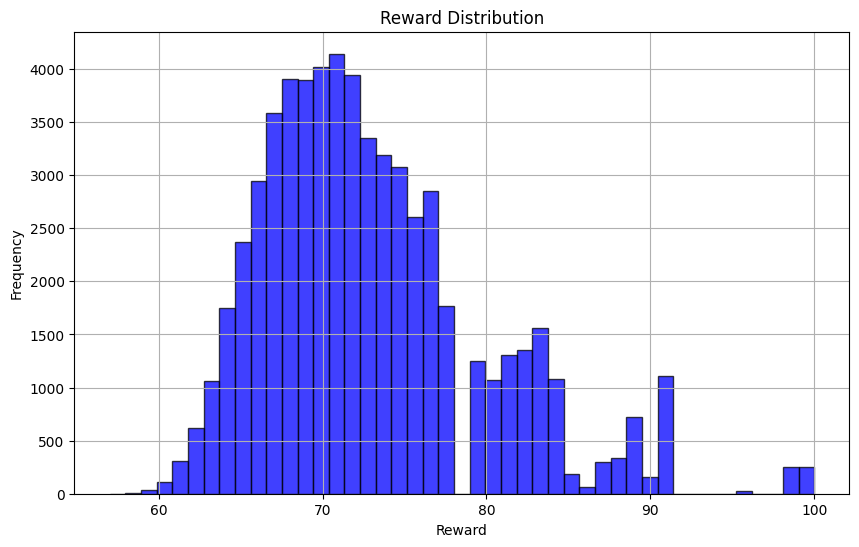

In [80]:
plot_histogram(rewards_parallel, bins=45)

In [81]:
list(zip(best_dataset['text'], best_dataset['reward']))

[('1100000010111111010011111101000000101111111010000001010000010111111010000010111111010000101111110100010111111010010111111010101111110101000000101111111010000001010000101000101001010101101101',
  100),
 ('1101000100101011001000111011010100110101100010001001100001010010000000111011010100110001001010110010100101011001100101011001110101001100101011001101011001101001101011001100110110010110110011',
  91),
 ('1101010110100011010010001001011100101100010010111001011110110100010010001001011100101010010000010001001011100101110100010010010111001011011100101100010010111001010011010011010110100101101101',
  91),
 ('1000011110010111001111100001001000110000111100101110010011110010111001011110010111001001001100000010001101000110001101000110010010001101101000110010111001001110001000110111001001100110110011',
  91),
 ('0110000011110101001110000011110101001011111000010001101111100001000110000010110111001000111101010010010110111001011110101001101101110010001000110000010000010001101000110111001001100110

In [ ]:
import subprocess


In [ ]:
gen_num = 5
samples = {}
rewards = {}
samples[0] = best_dataset['text']
rewards[0] = best_dataset['reward']


config = ModelConfig(vocab_size=101, block_size=42,
                       n_layer=2, n_head=4,
                       n_embd=16, n_embd2=32)
model = Transformer(config)


gen_batch_size = 10000
X_init = torch.zeros(gen_batch_size, 1, dtype=torch.long).to("cuda:3")
X_samp = generate(model, X_init, 189, temperature = 1, top_k=None, do_sample=True).to('cpu')
for i in range(1, gen_num):
    #1. tokenize the current generation and save to file
    text_data = samples[i - 1]
    with open("best_dataset_tokenized.txt", "w") as file:
        for i, sequence in enumerate(text_data):
            if i % 10000 == 0:
                print(f"{i} / {len(text_data)}")
            myids = tokenizer.encode(sequence).ids
            file.write(','.join(["V" + str(id) for id in myids]))
            file.write("\n")
    #2. train the model using script
    subprocess.run(["bash", "run_args.sh"], check=True)
    #3. generate from model (in batches and do not forget to empty cache)
    if i == 1:
        with open("best_dataset_tokenized.txt", 'r') as f:
            data = f.read()
        words = data.splitlines()
        words = [w.strip() for w in words] # get rid of any leading or trailing white space
        words = [w for w in words if w] # get rid of any empty strings
        max_word_length = max(len(w) for w in words)
        config = ModelConfig(vocab_size=101, block_size=max_word_length,
                       n_layer=2, n_head=4,
                       n_embd=16, n_embd2=32)
        model = Transformer(config)
    model.load_state_dict(torch.load("out/model.pt"))
    model.to("cuda:3")
    decoded_samples = []
    while len(decoded_samples) < 40000:
        new_samples = []
        X_init = torch.zeros(gen_batch_size, 1, dtype=torch.long).to("cuda:3")
        X_samp = generate(model, X_init, 189, temperature = 1, top_k=None, do_sample=True).to('cpu')
        torch.cuda.empty_cache()
        for i in range(X_samp.size(0)):
            row = X_samp[i, 1:].tolist()
            crop_index = row.index(0) if 0 in row else len(row)
            row = row[:crop_index]
            new_samples.append(row)

        for sample in new_samples:
            new_decoded_sample = tokenizer.decode(sample).replace(" ", "")
            if len(new_decoded_sample) >= 190:
                decoded_samples.append(new_decoded_sample[:190])
    #4. compute new generation and rewards
    tasks1 = [(None, s, N) for s in cut_samples]

    def process_task(args):
        return greedy_search_from_startpoint(*args)

    with Pool() as pool:
        new_generation = list(tqdm(pool.imap_unordered(process_task, tasks1),
                                total=len(tasks1)))
        
    tasks2 = [(s, N) for s in new_generation]

    def process_reward(args):
        return reward_calc(*args)

    with Pool() as pool:
        rewards_parallel = list(tqdm(pool.imap_unordered(process_reward, tasks2),
                                    total=len(tasks2)))

    print(rewards_parallel[:5])




In [ ]:

#subprocess.run(["bash", "run_args.sh"], check=True)

In [52]:
from triangle_free import greedy_search_from_startpoint, empty_starting_point, reward_calc

correct_rewards = [reward_calc(sample, N) for sample in correct_samples]
cut_rewards = [reward_calc(sample, N) for sample in cut_samples]

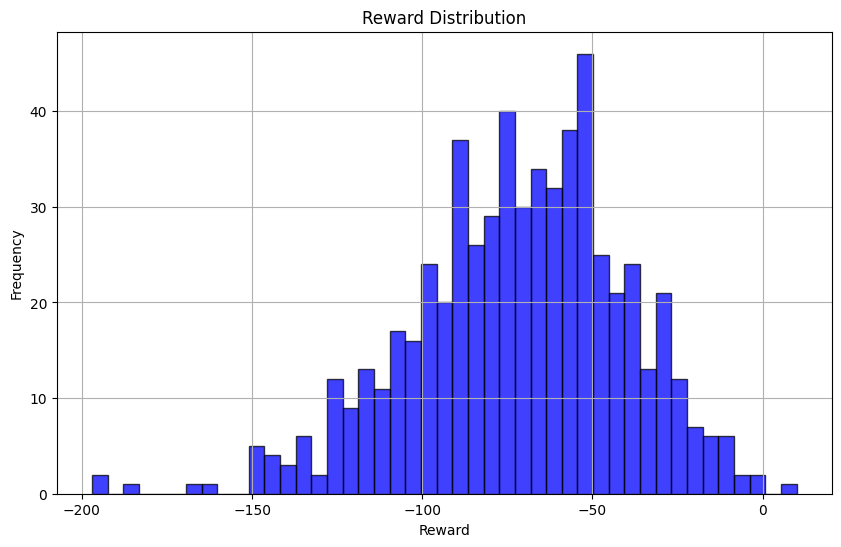

In [78]:
plot_histogram(cut_rewards, bins=45)

In [11]:
len(words[3])

190

In [12]:
list(set([i for word in words for i in word]))

['0', '1']

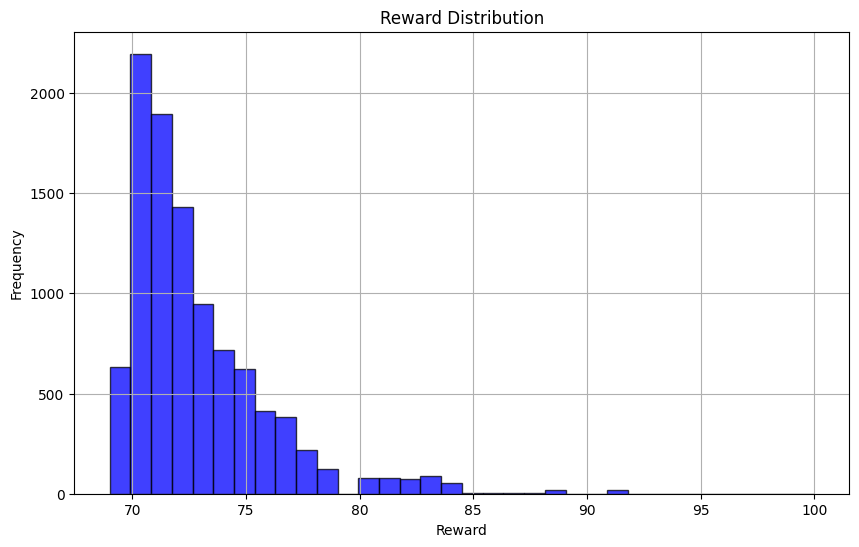

In [11]:
plot_histogram(best_dataset["reward"], bins=34)

#### Training the tokenizer

In [9]:
from tokenizers import Tokenizer, models, trainers, pre_tokenizers, processors, decoders

# Initialize the Tokenizer with a BPE model
tokenizer = Tokenizer(models.BPE())

# Set up the Trainer with desired parameters
trainer = trainers.BpeTrainer(
    vocab_size=100,
    special_tokens=["<s>", "</s>", "<pad>"],
    show_progress=True
)


tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()



# Train the tokenizer on the dataset
tokenizer.train_from_iterator(dataset['text'], trainer=trainer)


tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=tokenizer,
    clean_up_tokenization_spaces=True,
    bos_token="<s>",
    eos_token="</s>",
    pad_token="<pad>"
)

In [16]:
max_token_length = max([len(tokenizer.encode(text)) for text in dataset['text']])

In [17]:
tokenizer.save_pretrained(f"data/tokenizer_N{N}_samples40000")

('data/tokenizer_N20_samples40000/tokenizer_config.json',
 'data/tokenizer_N20_samples40000/special_tokens_map.json',
 'data/tokenizer_N20_samples40000/tokenizer.json')

In [18]:
def prepare_dataset(dataset: Dataset) -> Dataset:    
    def tokenize_function(examples):
        tokenized_inputs = tokenizer(
            examples["text"],
            padding=True,
            return_tensors="pt"
        )
        return tokenized_inputs
    
    tokenized_dataset = dataset.map(
        tokenize_function,
        batched=True
    )
    
    return tokenized_dataset

In [19]:
tokenized_dataset = prepare_dataset(best_dataset)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [22]:
config = GPT2Config(
            vocab_size=len(tokenizer),
            n_positions=max_token_length,  # Maximum length of our graph strings
            n_layer=2,
            n_head=4,
            n_embd=16,
            bos_token_id=tokenizer.bos_token_id,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
            torch_dtype=torch.bfloat16,
            torch_compile=True
        )

In [23]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda:0")

In [24]:
model = AutoModelForCausalLM.from_config(config)

# 5. Prepare a data collator for causal language modeling.
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

In [25]:
output_dir = f"data/"
training_args = TrainingArguments(
    output_dir=output_dir,
    max_steps=15000,
    per_device_train_batch_size=32,
    learning_rate=5e-4,
    weight_decay=0.01,
    eval_strategy="no",
    save_strategy="no",
    logging_dir=os.path.join(output_dir, "logs"),
    logging_steps=100,
    report_to="none",
    bf16=True,  # Enable bfloat16
    torch_compile=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    data_collator=data_collator
)

max_steps is given, it will override any value given in num_train_epochs


In [26]:
trainer.train()

Step,Training Loss
100,4.387600
200,4.179700
300,4.150400
400,4.125200
500,4.105500
600,4.082600
700,4.058800
800,4.037200
900,4.028600
1000,4.015500


TrainOutput(global_step=15000, training_loss=3.922339247639974, metrics={'train_runtime': 497.0904, 'train_samples_per_second': 965.619, 'train_steps_per_second': 30.176, 'total_flos': 757558124544.0, 'train_loss': 3.922339247639974, 'epoch': 47.92332268370607})

In [27]:
# Save dataset
print("Saving dataset...")
#dataset.save_to_disk(f"data/dataset_N{N}_samples{len(dataset)}_best")

# Save tokenizer
print("Saving tokenizer...")
tokenizer.save_pretrained(f"data/tokenizer_N{N}_samples{len(dataset)}")

# Save model
print("Saving model...")
model.save_pretrained(f"data/model_N{N}_samples{len(best_dataset)}_generation1")

print("Done saving all artifacts.")

Saving dataset...
Saving tokenizer...
Saving model...
Done saving all artifacts.


In [ ]:
num_samples = int(1e2)
batch_size = 32
generated_samples = []

for i in tqdm(range(0, num_samples, batch_size)):
    batch_input_ids = torch.tensor([[tokenizer.bos_token_id]] * min(batch_size, num_samples - i)).to(device)
    
    with torch.no_grad():
        outputs = model.generate(
            batch_input_ids,
            max_length=N * (N - 1) // 2,
            num_return_sequences=min(batch_size, num_samples - i),
            pad_token_id=tokenizer.pad_token_id,
            do_sample=True,
            temperature=1.0,
        )
        outputs = outputs.sequences if hasattr(outputs, 'sequences') else outputs
        generated_samples.extend([tokenizer.decode(output.tolist(), skip_special_tokens=True) for output in outputs])
    
    # Clear cache to free up memory
    torch.cuda.empty_cache()

In [29]:
batch_input_ids = torch.tensor([[tokenizer.bos_token_id]]).to(device)

In [30]:
batch_input_ids

tensor([[0]], device='cuda:0')

In [31]:
test_outputs = model.generate(
            batch_input_ids,
            max_length=max_token_length,
            num_return_sequences=int(1e2),
            pad_token_id=tokenizer.pad_token_id,
            do_sample=True,
            temperature=1.0,
        )

In [32]:
decoded_test_outputs = [''.join(s.split()) for s in tokenizer.batch_decode(test_outputs, skip_special_tokens=True)]

In [37]:
truncated_test_outputs = [s[:190] for s in decoded_test_outputs if len(s) >= 190]

In [ ]:
ones_count = [s.count('1') for s in truncated_test_outputs]
print(f"Average number of 1's: {sum(ones_count)/len(ones_count):.2f}")
print(f"Min number of 1's: {min(ones_count)}")
print(f"Max number of 1's: {max(ones_count)}")

In [39]:
new_reward = [reward_calc(graph, N) for graph in truncated_test_outputs]

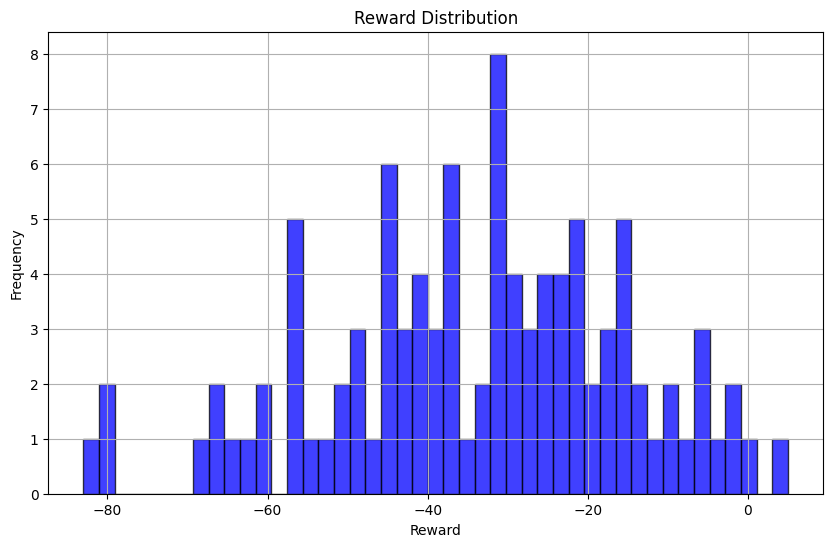

In [41]:
plot_histogram(new_reward, bins=45)

In [42]:
new_reward_simple = [graph.count('1') for graph in truncated_test_outputs]

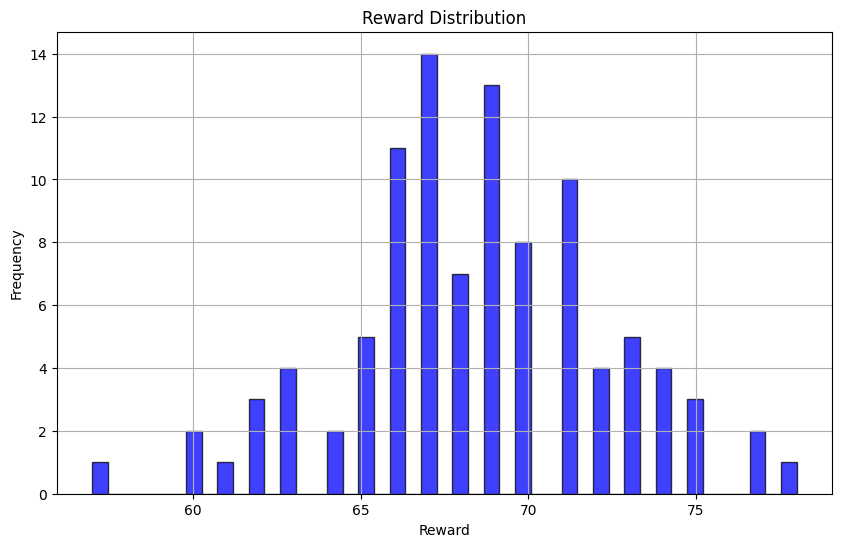

In [43]:
plot_histogram(new_reward_simple, bins=45)

In [100]:
''.join(tokenizer.decode(tokenizer.encode("1010110101010010100111100101"), skip_special_tokens=True, clean_up_tokenization_spaces=True).split()) == "1010110101010010100111100101"

True

In [ ]:
def clean_graph_string(graph_string: str) -> str:
    """Remove all whitespaces from a graph string."""
    return ''.join(graph_string.split())

# Clean the generated samples
generated_samples = [clean_graph_string(sample) for sample in generated_samples]

In [ ]:
samples = model.generate_samples(samples_per_generation)

# Run greedy search on generated samples
new_samples = []
for sample in tqdm(samples, desc="Running greedy search"):
    try:
        # Skip invalid samples
        if len(sample) != N * (N - 1) // 2 or not all(c in '01' for c in sample):
            continue
        result = greedy_search_from_startpoint(None, sample, N)
        reward = reward_calc(result, N)
        new_samples.append({"text": result, "reward": reward})
    except Exception as e:
        logger.warning(f"Error processing sample: {e}")

In [ ]:
# X_init = torch.zeros(num, 1, dtype=torch.long).to(args.device)
# top_k = args.top_k if args.top_k != -1 else None
# steps = train_dataset.get_output_length() - 1 # -1 because we already start with <START> token (index 0)
# X_samp = generate(model, X_init, steps, temperature = args.temperature, top_k=top_k, do_sample=True).to('cpu')
'''
def get_parser():
    parser = argparse.ArgumentParser('Generate training sample of low braids via reservoir sampling')
    # JULIA params
    
    parser.add_argument('--num_initial_empty_objects', type=int, default=50000, help='number of initial rollouts, before the first learning loop')
    parser.add_argument('--final_database_size', type=int, default=5000, help='training set size')
    parser.add_argument('--target_db_size', type=int, default=50000, help='size of cache during local search loop, should be larger than training set size')
    parser.add_argument('--sample-only', type=int, default=50000, help="sample the specified number from the model in each loop")
    parser.add_argument('--nb_threads', type=int, default=8, help='Number of cpu threads')
    parser.add_argument('--nb_local_searches', type=int, default=1200, help='This only matters when using multithreading, then it should be a multiple of the number of threads used')
    

    # Makemore params
    parser.add_argument('--num-workers', '-n', type=int, default=8, help="number of data workers for both train/test")
    parser.add_argument('--max-steps', type=int, default=2000, help="max number of optimization steps to run for, or -1 for infinite.")
    parser.add_argument('--max_epochs', type=int, default= 300, help='number of epochs')
    parser.add_argument('--seed', type=int, default=-1, help="seed")
    # sampling
    parser.add_argument('--top-k', type=int, default=-1, help="top-k for sampling, -1 means no top-k")
    # model
    parser.add_argument('--type', type=str, default='transformer', help="model class type to use, bigram|mlp|rnn|gru|bow|transformer")
    parser.add_argument('--n-layer', type=int, default=2, help="number of layers")
    parser.add_argument('--n-head', type=int, default=4, help="number of heads (in a transformer)")
    parser.add_argument('--n-embd', type=int, default=16, help="number of feature channels in the model")
    parser.add_argument('--n-embd2', type=int, default=32, help="number of feature channels elsewhere in the model")
    # optimization
    parser.add_argument('--batch-size', '-b', type=int, default=16, help="batch size during optimization")
    parser.add_argument('--learning-rate', '-l', type=float, default=5e-4, help="learning rate")
    parser.add_argument('--weight-decay', '-w', type=float, default=0.01, help="weight decay")
    # evaluation against known "good sequences"
    parser.add_argument('--max-output-length', type=int, default=160, help="maximum output length")
    parser.add_argument('--gen_batch_size', type=int, default=1000, help="generation batch size")
    parser.add_argument('--n_tokens', type=int, default=100, help="nr tokens in tokenizer")
    parser.add_argument('--temperature', type=float, default=1.0, help="temperature")
'''